In [0]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

In [0]:
handle = 'nike'

{'contributors': None,
 'coordinates': None,
 'created_at': 'Sat Dec 15 19:23:34 +0000 2018',
 'entities': {'hashtags': [],
  'media': [{'display_url': 'pic.twitter.com/qNFZMPXAJe',
    'expanded_url': 'https://twitter.com/cfrichardson1/status/1074022172014727168/photo/1',
    'id': 1074022170416668672,
    'id_str': '1074022170416668672',
    'indices': [10, 33],
    'media_url': 'http://pbs.twimg.com/media/DuexeTyUYAARRbz.jpg',
    'media_url_https': 'https://pbs.twimg.com/media/DuexeTyUYAARRbz.jpg',
    'sizes': {'large': {'h': 396, 'resize': 'fit', 'w': 576},
     'medium': {'h': 396, 'resize': 'fit', 'w': 576},
     'small': {'h': 396, 'resize': 'fit', 'w': 576},
     'thumb': {'h': 150, 'resize': 'crop', 'w': 150}},
    'type': 'photo',
    'url': 'https://t.co/qNFZMPXAJe'}],
  'symbols': [],
  'urls': [],
  'user_mentions': []},
 'extended_entities': {'media': [{'display_url': 'pic.twitter.com/qNFZMPXAJe',
    'expanded_url': 'https://twitter.com/cfrichardson1/status/10740221720

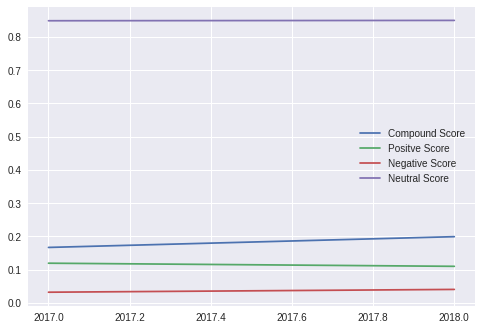

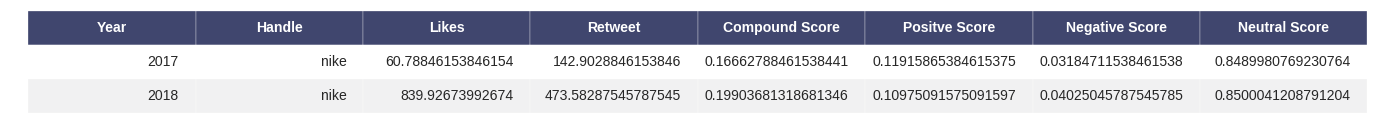

In [29]:
!pip install tweepy
!pip install vaderSentiment

from google.colab import files


from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pprint import pprint
import six
import tweepy


from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

def df_creator(tweets):
  # WANTED List to hold wanted information from tweets
  date = []
  favorite_count = []
  name = []
  retweet = []
  text = []
  id_ = []

  # Loop through the list of tweets to grab needed info
  for tweet in tweets:
    date.append(tweet['created_at'])
    favorite_count.append(tweet['favorite_count'])
    retweet.append(tweet['retweet_count'])
    text.append(tweet['full_text'])
    id_.append(tweet['id'])

  # Create DF based on WANTED lists
  df = pd.DataFrame({
      'Created': date,
      'Likes': favorite_count,
      'Retweet': retweet,
      'Text': text,
      'ID': id_,
  })
  
  # Convert date to datetime dtype
  df['Created'] = [datetime.strptime(date, "%a %b %d %H:%M:%S %z %Y") for date in df['Created']]
  
  return df

# Analyze Pulled Tweets and get Compound, Positive, Negative, & Neutral Scores
def sentiment_analyzer(df):
  # Setup sentiment analyzer
  analyzer = SentimentIntensityAnalyzer()
  
  # Variables for holding sentiments
  compound_list = []
  positive_list = []
  negative_list = []
  neutral_list = []

  # Loop through Tweets
  for text in df['Text']:

    # Run Vader Analysis on each tweet
    results = analyzer.polarity_scores(text)
    compound = results["compound"]
    pos = results["pos"]
    neu = results["neu"]
    neg = results["neg"]

    # Add each value to the appropriate list
    compound_list.append(compound)
    positive_list.append(pos)
    negative_list.append(neg)
    neutral_list.append(neu)

  df['Compound Score'] = compound_list
  df['Positve Score'] = positive_list
  df['Negative Score'] = negative_list
  df['Neutral Score'] = neutral_list
  
  return df

 
def user_tweets(user, api, consumer_key, consumer_secret, access_token, access_token_secret,endpage = 26):
  target_user = ('@'+user)

  # List to store dictionaries of tweets
  tweets = []

  # Loop through 25 pages of tweets and grab 500 tweets
  for x in range(1, endpage):

    for tweet in api.user_timeline(target_user, page=x, tweet_mode='extended'):
      tweets.append(tweet)

  # Convert list of dicitonary tweets into a dataframe
  tweet_df = df_creator(tweets)
  
  # Reset index to date created for Group By purposes
  tweet_df = tweet_df.set_index('Created')
  
  tweet_df = sentiment_analyzer(tweet_df)

  final_df = tweet_df.resample('Y').mean()

  final_df['Handle'] = user
  
  final_df.index = [date.year for date in final_df.index]

  return final_df[['Handle','Likes', 'Retweet', 'Compound Score', 'Positve Score', 'Negative Score',
         'Neutral Score']]

# Convert Pandas DF to Png format
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax
  
response = user_tweets(user=handle,api=api,consumer_key=consumer_key,consumer_secret=consumer_secret, access_token=access_token, access_token_secret=access_token_secret, endpage = 200)
# Render response to a time series chart
ax = response[['Compound Score','Positve Score','Negative Score', 'Neutral Score']].plot()
fig = ax.get_figure()
fig.savefig('time_plot.png')

response = response.reset_index()
response = response.rename(index=str, columns = {'index':'Year'})

# Render response to PNG
render_mpl_table(response).get_figure().savefig('table.png')

api.update_with_media('table.png', 'test table')
api.update_with_media('time_plot.png', 'test plot')